In [1]:
import pandas as pd

from tqdm import tqdm
from xml.etree import ElementTree as ET
from networkx import Graph, DiGraph
import numpy as np
# import glasbey
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from pathlib import Path

In [2]:
track_path = Path(r"D:\FeedbackControl\data\results\tracks")
savepath = Path(r"Supplementary Figures")
import matplotlib as mpl
mpl.rc("axes", facecolor="#ffffff00", grid=False, edgecolor="k", labelcolor="k")
mpl.rc("figure", facecolor="#00000000", dpi=100)
mpl.rc("axes.spines", top=False, right=False, )
mpl.rc("xtick", color="k", bottom=True)
mpl.rc("ytick", color="k", left=True)
mpl.rc("legend", fontsize="small")

In [8]:
import matplotlib as mpl
from collections import defaultdict

experiments = defaultdict(list)

subset_dfs = []
barspeeds = []

pal = plt.get_cmap("viridis")

for src in list(track_path.iterdir()):
    if not src.name.endswith(".csv"):
        continue

    if src.stem[:3] != "bar":
        continue

    spots_df = pd.read_csv(src)


    spots_df["id"] = spots_df.index
    spots_df["parent"] = spots_df.groupby("track_id").shift(1)["id"]
    spots_df["parent"] = spots_df["parent"].fillna(-1).astype(int)
    spots_df["um_x"] = spots_df["px_x"] * 0.66
    spots_df["um_y"] = spots_df["px_y"] * 0.66
    spots_df["t"] = spots_df["frame"] * 5
    spots_df["t_hour"] = spots_df["t"] // 60
    spots_df["t_2hour"] = spots_df["t"] // 120 * 2
    spots_df["dif_frame"] = spots_df["frame"] - spots_df.groupby("track_id").shift(1)["frame"]

    barstr = src.stem.split(".")[0][3:]
    # batch = src.stem.split(".")[1][1]
    # replicate = src.stem.split(".")[1][0]
    # barstr = barstr.replace("p", ".")

    bar_speed = int(barstr) / (10**(len(barstr) - 1))
    # bar_speed = float(barstr)
    batch = 0
    replicate = int(src.stem.split(".")[1][1])

    if bar_speed == 0:
        bar_speed = 0.00000001

    barspeeds.append(bar_speed)

    period = 100
    period_time = period / bar_speed
    duty_cycle = 0.2

    spots_df["phase"] = ((spots_df["t"] - (spots_df["um_y"] / bar_speed)) % period_time) / period_time
    spots_df["phase_coarse"] = (spots_df["phase"] // 0.1) * 0.1
    spots_df["phase_fine"] = (spots_df["phase"] // 0.05) * 0.05

    spots_df["Relative Cell Position"] = [-(p - 0.1) if p < 0.6 else -(p - 0.1) + 1.0 for p in spots_df["phase"]]
    # all_dfs["Relative Cell Positions"]
    spots_df["Relative Cell Position"] = pd.cut(spots_df["Relative Cell Position"], bins=15)
    spots_df["Relative Cell Position"] = [(p.right + p.left) / 2 for p in spots_df["Relative Cell Position"]]
    spots_df["Relative Cell Position"] = spots_df["Relative Cell Position"] * -2*np.pi

    spots_df["speed"] = bar_speed
    spots_df["batch"] = batch
    spots_df["replicate"] = replicate

    for col in ["px_x", "px_y", "um_x", "um_y"]:
        spots_df[f"parent_{col}"] = spots_df.groupby("track_id").shift(1)[col]
        spots_df[f"dif_{col}"] = (spots_df[col] - spots_df[f"parent_{col}"]) / spots_df["dif_frame"]
        spots_df[f"{col}_per_min"] = spots_df[f"dif_{col}"] / 5
        spots_df[f"{col}_per_h"] = spots_df[f"dif_{col}"] * 12

    spots_df["um_speed"] = np.sqrt(spots_df["um_x_per_min"] ** 2 + spots_df["um_y_per_min"] ** 2)

    # spots_df["dif_px_x"] = spots_df["dif_px_x"] / spots_df["dif_frame"]

    subset = spots_df[
        (spots_df["px_x"] > 400) &
        (spots_df["px_x"] < 1200) &
        (spots_df["px_y"] > 400) &
        (spots_df["px_y"] < 1200) &
        (spots_df["t"].between(0, (60*10)-1))
        # (spots_df["um_speed"] > spots_df["um_speed"].quantile(0.90))
    ].copy()
    n_cells_tot = len(spots_df[spots_df["frame"] == spots_df["frame"].max()])
    n_cells_here = len(subset[subset["frame"] == subset["frame"].max()])
    print(bar_speed * 60, replicate, n_cells_tot, n_cells_here)


    subset_dfs.append(subset)

    experiments["bar_speed"].append(bar_speed)
    experiments["avg_speed"].append(subset[subset["t_hour"].between(3, 7)]["um_y_per_min"].mean())
    experiments["median_speed"].append(subset[subset["t_hour"].between(3, 7)]["um_y_per_min"].median())
    experiments["top_speed"].append(subset[subset["t_hour"].between(3, 7)]["um_y_per_min"].quantile(0.9))
    experiments["n_cells"].append(subset[subset["t_hour"].between(3, 7)].groupby("frame")["um_x"].count().mean())
    experiments["avg_speed_any"].append(subset[subset["t_hour"].between(3, 7)]["um_speed"].mean())
    experiments["batch"].append(batch)
    experiments["replicate"].append(replicate)

6e-07 0 1128 352
6e-07 1 1544 466
6.0 0 1057 333
6.0 1 2053 515
6.0 2 1281 451
12.0 0 2444 693
12.0 1 1725 431
12.0 2 1335 420
12.0 3 1674 459
12.0 4 2205 565
18.0 2 2917 836
18.0 3 1427 383
18.0 4 1463 365
24.0 2 2858 808
24.0 3 1568 455
24.0 4 1452 397
24.0 5 1494 381
30.0 3 1780 476
30.0 4 1474 377
30.0 5 2134 549
39.6 0 2877 850
39.6 1 2454 716
39.6 2 1678 506
49.8 0 2841 811
49.8 1 1488 428
49.8 2 1966 655


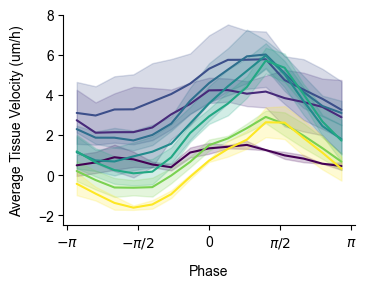

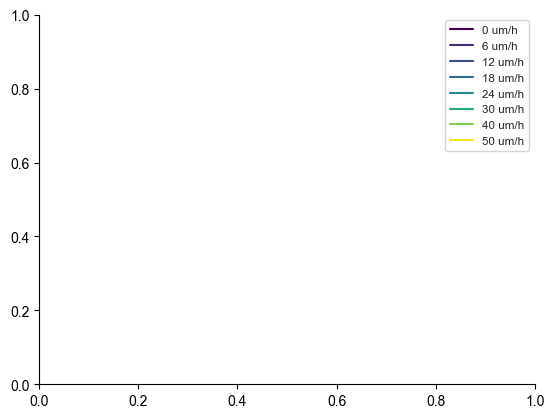

In [22]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plt.tight_layout(rect = [0.05, 0.05, 0.95, 0.95])
all_dfs = pd.concat(subset_dfs, ignore_index=True)
all_dfs["Bar Speed (um/h)"] = all_dfs["speed"] * 60
all_dfs["Average Cell Velocity (um/h)"] = all_dfs["um_y_per_min"] * 60

t = all_dfs.groupby(["speed", "replicate", "Relative Cell Position"], as_index=False).mean()
t["speed"] =np.round(t["speed"], 2)
t["Bar Speed (um/h)"] =np.round(t["Bar Speed (um/h)"], 0)

max_speed = t["Bar Speed (um/h)"].max()
colors = [sns.color_palette("viridis", as_cmap=True)(s / max_speed) for s in t["Bar Speed (um/h)"].unique()]
sns.lineplot(t, x="Relative Cell Position", y="Average Cell Velocity (um/h)", hue="Bar Speed (um/h)", errorbar=("sd", 1), palette="viridis", legend=False)

ax.grid(False)

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
plt.xlabel("Phase")
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], labels=["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])
labels=[f"{int(k)} um/h" for k in t["Bar Speed (um/h)"].unique()]
lines = []
for c, lab in zip(colors, labels):
    lines.append(Line2D([0, 0], [0, 0], color=c))

plt.ylabel("Average Tissue Velocity (um/h)")
plt.ylim(-2.5, 8)

plt.savefig(savepath / "all_phases.pdf")
plt.show()

plt.figure()

plt.legend(handles=lines, labels=labels)
plt.savefig(savepath / "all_phases_LEGEND.pdf")
plt.show()

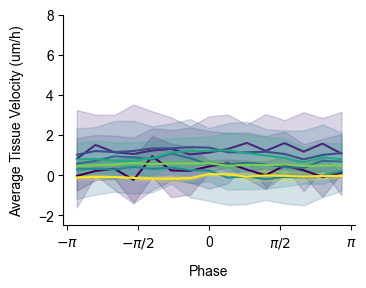

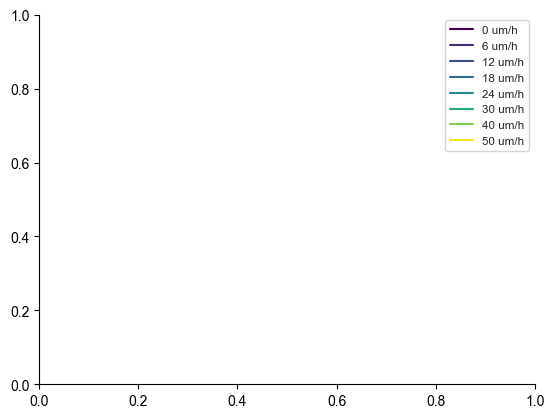

In [23]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plt.tight_layout(rect = [0.05, 0.05, 0.95, 0.95])
all_dfs = pd.concat(subset_dfs, ignore_index=True)
all_dfs["Bar Speed (um/h)"] = all_dfs["speed"] * 60
all_dfs["Average Cell Velocity (um/h)"] = all_dfs["um_x_per_min"] * 60

t = all_dfs.groupby(["speed", "replicate", "Relative Cell Position"], as_index=False).mean()
t["speed"] =np.round(t["speed"], 2)
t["Bar Speed (um/h)"] =np.round(t["Bar Speed (um/h)"], 0)

max_speed = t["Bar Speed (um/h)"].max()
colors = [sns.color_palette("viridis", as_cmap=True)(s / max_speed) for s in t["Bar Speed (um/h)"].unique()]
sns.lineplot(t, x="Relative Cell Position", y="Average Cell Velocity (um/h)", hue="Bar Speed (um/h)", errorbar=("sd", 1), palette="viridis", legend=False)

ax.grid(False)

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
plt.xlabel("Phase")
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], labels=["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])
labels=[f"{int(k)} um/h" for k in t["Bar Speed (um/h)"].unique()]
lines = []
for c, lab in zip(colors, labels):
    lines.append(Line2D([0, 0], [0, 0], color=c))

plt.ylabel("Average Tissue Velocity (um/h)")
plt.ylim(-2.5, 8)

plt.savefig(savepath / "all_phases_x_direction.pdf")
plt.show()

plt.figure()

plt.legend(handles=lines, labels=labels)
# plt.savefig(savepath / "all_phases_LEGEND.pdf")
plt.show()

0.034188865441858514
0.2


C:\Users\Harrison\AppData\Local\Temp\ipykernel_24856\2057150794.py:43: UserWarning: 
The palette list has fewer values (1) than needed (227) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(df2, x="t_rel", y="Velocity (um/h)", errorbar=None, alpha=0.1, hue="track_id", legend=False, palette=[color])


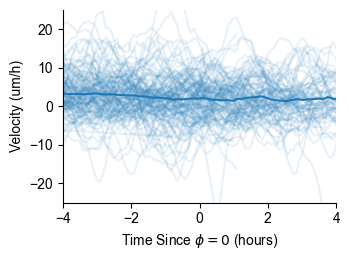

0.0002925927467695938
0.83


C:\Users\Harrison\AppData\Local\Temp\ipykernel_24856\2057150794.py:43: UserWarning: 
The palette list has fewer values (1) than needed (262) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(df2, x="t_rel", y="Velocity (um/h)", errorbar=None, alpha=0.1, hue="track_id", legend=False, palette=[color])


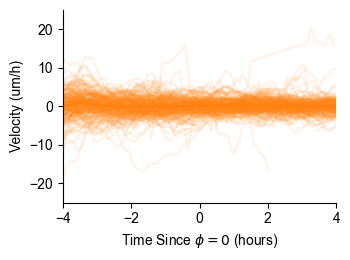

In [29]:
for n, color in zip([5, 25], ["C0", "C1"]):
    df2 = subset_dfs[n].copy()
    print(df2["um_x_per_min"].mean())
    print(df2["speed"].mean())
    speed = int(np.round(df2["speed"].mean()*60, 0))

    df2["track_start"] = df2["track_id"].map(df2.groupby("track_id")["t"].min())
    df2["track_end"] = df2["track_id"].map(df2.groupby("track_id")["t"].max())

    # print(df2["track_end"])

    df2 = df2[(df2["track_start"] < 30) & (df2["track_end"] > 60*7)].copy()

    df2["abs_phase"] = df2["Relative Cell Position"].abs()
    df2["track_min_phase"] = df2["track_id"].map(df2.groupby("track_id")["abs_phase"].min())
    df2 = df2[df2["track_min_phase"] == 0].copy()
    df2["is_zero"] = df2["Relative Cell Position"] == 0

    random_tracks = df2["track_id"].sample(500)
    df2 = df2[df2["track_id"].isin(random_tracks)]

    later_tps = df2[df2["t"] > 240].copy()

    later_tps["track_min_phase"] = later_tps["track_id"].map(later_tps.groupby("track_id")["abs_phase"].min())
    later_tps = later_tps[later_tps["track_min_phase"] == 0]

    t = df2["track_id"].map(later_tps.groupby("track_id")["is_zero"].idxmax().map(later_tps["t"]))
    x = df2["track_id"].map(later_tps.groupby("track_id")["is_zero"].idxmax().map(later_tps["um_x"]))

    df2["t_rel"] = (df2["t"] - t) / 60
    df2["x_rel"] = df2["um_x"] - x

    df2["x_smooth"] = df2.groupby("track_id").rolling(window=10, min_periods=1, center=True)["um_x_per_min"].mean().reset_index(level=0, drop=True)
    df2["Velocity (um/h)"] = df2["x_smooth"] * 60

    sns.scatterplot(df2, x="t_rel", y="Relative Cell Position", alpha=0.05, s=2.0)
    sns.lineplot(df2, x="t_rel", y="Relative Cell Position")
    plt.xlim(-4, 4)
    plt.close()


    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    sns.lineplot(df2, x="t_rel", y="Velocity (um/h)", errorbar=None, alpha=0.1, hue="track_id", legend=False, palette=[color])
    sns.lineplot(df2, x="t_rel", y="Velocity (um/h)", errorbar=None, alpha=1, legend=False, color=color)

    plt.xlabel("Time Since $\phi=0$ (hours)")
    plt.xlim(-4, 4)
    plt.xticks([-4, -2, 0, 2, 4])
    plt.ylim(-25, 25)
    plt.tight_layout(rect = [0.05, 0.05, 0.95, 0.95])
    plt.savefig(savepath / f"X_direction_{speed}umph_singlecelltracks_rollingmean.pdf")

    plt.show()


Index(['label', 'area', 'px_y', 'px_x', 'frame', 'tree_id', 'track_id', 'id',
       'parent', 'um_x', 'um_y', 't', 't_hour', 't_2hour', 'dif_frame',
       'phase', 'phase_coarse', 'phase_fine', 'Relative Cell Position',
       'batch', 'parent_px_x', 'dif_px_x', 'px_x_per_min', 'px_x_per_h',
       'parent_px_y', 'dif_px_y', 'px_y_per_min', 'px_y_per_h', 'parent_um_x',
       'dif_um_x', 'um_x_per_min', 'um_x_per_h', 'parent_um_y', 'dif_um_y',
       'um_y_per_min', 'um_y_per_h', 'um_speed', 'Bar Speed (um/h)',
       'Average Cell Velocity (um/h)'],
      dtype='object')


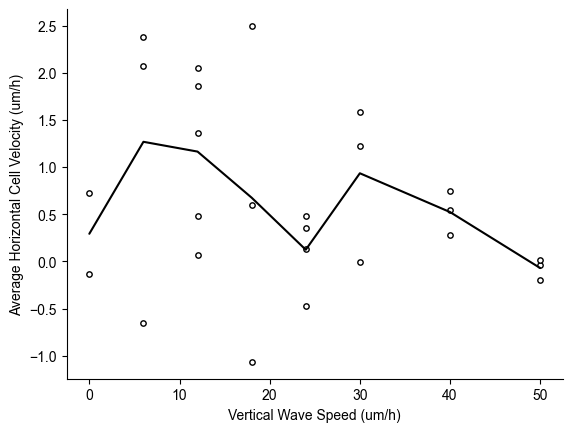

Index(['label', 'area', 'px_y', 'px_x', 'frame', 'tree_id', 'track_id', 'id',
       'parent', 'um_x', 'um_y', 't', 't_hour', 't_2hour', 'dif_frame',
       'phase', 'phase_coarse', 'phase_fine', 'Relative Cell Position',
       'batch', 'parent_px_x', 'dif_px_x', 'px_x_per_min', 'px_x_per_h',
       'parent_px_y', 'dif_px_y', 'px_y_per_min', 'px_y_per_h', 'parent_um_x',
       'dif_um_x', 'um_x_per_min', 'um_x_per_h', 'parent_um_y', 'dif_um_y',
       'um_y_per_min', 'um_y_per_h', 'um_speed', 'Bar Speed (um/h)',
       'Average Cell Velocity (um/h)'],
      dtype='object')


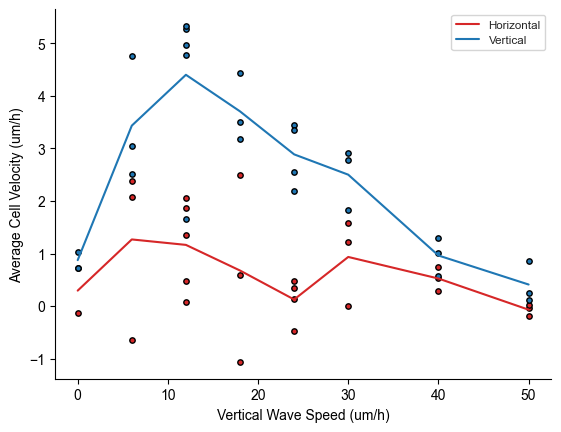

In [41]:
t = all_dfs.groupby(["replicate", "speed"]).mean()
t["Bar Speed (um/h)"] = np.round(t["Bar Speed (um/h)"], 0)
print(t.columns)
# t["x_speed_h"]

sns.scatterplot(data=t, x="Bar Speed (um/h)", y="um_x_per_h", color="white", edgecolor="k", linewidth=1.0, s=15)
sns.lineplot(data=t, x="Bar Speed (um/h)", y="um_x_per_h", errorbar=None, color="k")

plt.xlabel("Vertical Wave Speed (um/h)")
plt.ylabel("Average Horizontal Cell Velocity (um/h)")

plt.savefig(savepath / "X_barspeeds.pdf")
plt.show()

# t = all_dfs.groupby(["replicate", "speed"]).mean()
print(t.columns)
# t["x_speed_h"]

sns.scatterplot(data=t, x="Bar Speed (um/h)", y="um_x_per_h", color="C3", edgecolor="k", linewidth=1.0, s=15)
sns.lineplot(data=t, x="Bar Speed (um/h)", y="um_x_per_h", errorbar=None, color="C3", label="Horizontal")

sns.scatterplot(data=t, x="Bar Speed (um/h)", y="um_y_per_h", color="C0", edgecolor="k", linewidth=1.0, s=15)
sns.lineplot(data=t, x="Bar Speed (um/h)", y="um_y_per_h", errorbar=None, color="C0", label="Vertical")

plt.xlabel("Vertical Wave Speed (um/h)")
plt.ylabel("Average Cell Velocity (um/h)")

plt.savefig(savepath / "X_vs_Y_barspeeds.pdf")
plt.show()

In [9]:
import matplotlib as mpl
from collections import defaultdict
from tqdm import tqdm

circle_track_path = Path(r"D:\FeedbackControl\data\circle_tracks")

all_subsets = []

for i in tqdm(range(3)):

    spots_df = pd.read_csv(circle_track_path / f"circle125.0{i}_tracks.csv")

    um_per_px = 0.66

    spots_df["id"] = spots_df.index
    spots_df["parent"] = spots_df.groupby("track_id").shift(1)["id"]
    spots_df["parent"] = spots_df["parent"].fillna(-1).astype(int)
    spots_df["um_x"] = spots_df["px_x"] * um_per_px
    spots_df["um_y"] = spots_df["px_y"] * um_per_px
    spots_df["t"] = spots_df["frame"] * 5
    spots_df["t_hour"] = spots_df["t"] // 60
    # spots_df["t_2hour"] = spots_df["t"] // 120 * 2
    spots_df["dif_frame"] = spots_df["frame"] - spots_df.groupby("track_id").shift(1)["frame"]

    center_x, center_y = 800, 800
    center_x_um, center_y_um = center_x * um_per_px, center_y * um_per_px

    spots_df["um_r"] = np.sqrt((spots_df["um_x"] - center_x_um) ** 2 + (spots_df["um_y"] - center_y_um) ** 2)
    spots_df["theta"] = np.arctan2(spots_df["um_y"] - center_y_um, spots_df["um_x"] - center_x_um)

    spots_df["unit_tangent_x"] = -(spots_df["um_y"] - center_y_um) / spots_df["um_r"]
    spots_df["unit_tangent_y"] = (spots_df["um_x"] - center_x_um) / spots_df["um_r"]

    spots_df["unit_radial_x"] = (spots_df["um_x"] - center_x_um) / spots_df["um_r"]
    spots_df["unit_radial_y"] = (spots_df["um_y"] - center_y_um) / spots_df["um_r"]

    # print(spots_df["unit_tangent_y"].describe())

    for col in ["px_x", "px_y", "um_x", "um_y"]:
        spots_df[f"parent_{col}"] = spots_df.groupby("track_id").shift(1)[col]
        spots_df[f"dif_{col}"] = (spots_df[col] - spots_df[f"parent_{col}"]) / spots_df["dif_frame"]
        spots_df[f"{col}_per_min"] = spots_df[f"dif_{col}"] / 5
        spots_df[f"{col}_per_h"] = spots_df[f"dif_{col}"] * 12

    spots_df["um_tangent_per_min"] = -((spots_df["um_x_per_min"] * spots_df["unit_tangent_x"]) + (spots_df["um_y_per_min"] * spots_df["unit_tangent_y"]))
    spots_df["um_radial_per_min"] = (spots_df["um_x_per_min"] * spots_df["unit_radial_x"]) + (spots_df["um_y_per_min"] * spots_df["unit_radial_y"])

    spots_df["um_speed"] = np.sqrt(spots_df["um_x_per_min"] ** 2 + spots_df["um_y_per_min"] ** 2)

    spots_df["um_x_per_min_rolling"] = spots_df.groupby("track_id").rolling(window=10, min_periods=1)["um_x_per_min"].mean().reset_index(level=0, drop=True)
    spots_df["um_y_per_min_rolling"] = spots_df.groupby("track_id").rolling(window=10, min_periods=1)["um_y_per_min"].mean().reset_index(level=0, drop=True)
    spots_df["um_tangent_per_min_rolling"] = spots_df.groupby("track_id").rolling(window=10, min_periods=1)["um_tangent_per_min"].mean().reset_index(level=0, drop=True)
    spots_df["um_radial_per_min_rolling"] = spots_df.groupby("track_id").rolling(window=10, min_periods=1)["um_radial_per_min"].mean().reset_index(level=0, drop=True)

    spots_df["Tangential Velocity (um/h)"] = spots_df["um_tangent_per_min"] * 60
    spots_df["Radial Velocity (um/h)"] = spots_df["um_radial_per_min"] * 60

    spots_df["replicate"] = i

    subset = spots_df[
        (spots_df["t"].between(0, (60*6)-1))
    ].copy()

    n_cells_tot = len(spots_df[spots_df["frame"] == spots_df["frame"].max()])
    n_cells_here = len(subset[subset["frame"] == subset["frame"].max()])
    print(bar_speed * 60, replicate, n_cells_tot, n_cells_here)

    all_subsets.append(subset)

 33%|███▎      | 1/3 [00:02<00:05,  2.99s/it]

49.8 2 1866 1863


 67%|██████▋   | 2/3 [00:05<00:02,  2.59s/it]

49.8 2 1048 1606


100%|██████████| 3/3 [00:07<00:00,  2.64s/it]

49.8 2 2385 1825


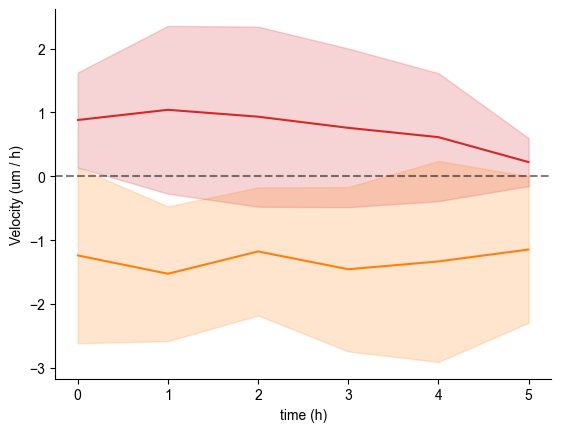

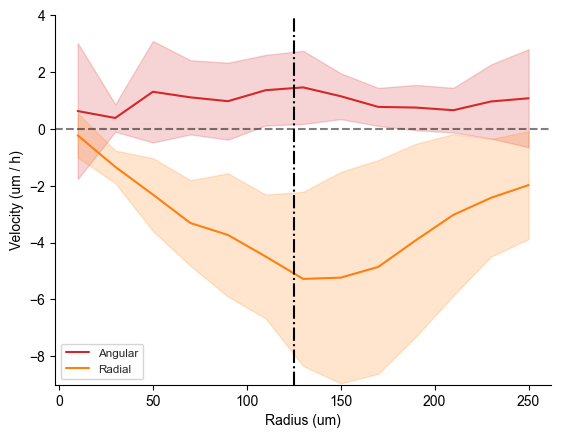

In [80]:
full_dfs = pd.concat(all_subsets, ignore_index=True)

t = full_dfs.groupby(["replicate", "t_hour"], as_index=False).mean()
t["t_hour_offset"] = t["t_hour"]

sns.lineplot(t, x="t_hour_offset", y="Tangential Velocity (um/h)", color="C3", errorbar=("sd", 1))
sns.lineplot(t, x="t_hour_offset", y="Radial Velocity (um/h)", color="C1", errorbar=("sd", 1))
plt.xlabel("time (h)")
plt.ylabel("Velocity (um / h)")
plt.axhline(0, color="black", linestyle="--", alpha=0.5)
# plt.legend()
plt.savefig(savepath / "circle_velocities.pdf")
plt.show()

full_dfs["um_r_bin"] = (full_dfs["um_r"] // 20) * 20 + 10

# plt.legend()
t = full_dfs.groupby(["replicate", "um_r_bin"], as_index=False).mean()

sns.lineplot(t[t["um_r_bin"] < 400/1.5], x="um_r_bin", y="Tangential Velocity (um/h)", errorbar=("sd", 1), err_style="band", label="Angular", color="C3")
sns.lineplot(t[t["um_r_bin"] < 400/1.5], x="um_r_bin", y="Radial Velocity (um/h)", errorbar=("sd", 1), err_style="band", label="Radial", color="C1")

plt.axvline(125, color="black", linestyle="-.", alpha=1.0)
plt.xlabel("Radius (um)")
plt.ylabel("Velocity (um / h)")
plt.ylim(-9, 4)
plt.axhline(0, color="black", linestyle="--", alpha=0.5)
plt.savefig(savepath / "circle_velocities_by_radius.pdf")
plt.show()

799.0
1127


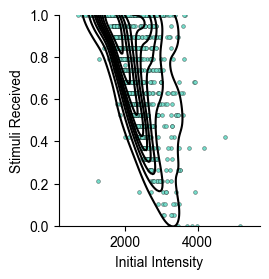

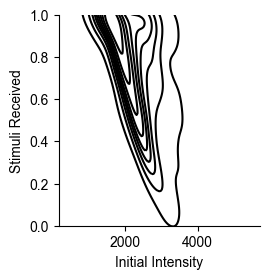

In [5]:
tracks_path = r"D:\FeedbackControl\data\RTx3 imaging\tagrfp\tracked.csv"
tracked_spots_df = pd.read_csv(tracks_path)
tracked_spots_df["intensity"] = tracked_spots_df["intensity_mean-0"]
tracked_spots_df["seg-label"] = tracked_spots_df["intensity_mean-1"]
tracked_spots_df["stim"] = tracked_spots_df["intensity_mean-2"] > 0
tracked_spots_df["Time (mins)"] = tracked_spots_df["frame"] / 2
tracked_spots_df["track_n_spots"] = tracked_spots_df["track_id"].map(tracked_spots_df.groupby("track_id")["frame"].count())
print(tracked_spots_df["px_x"].max())
good_tracked_spots = tracked_spots_df[tracked_spots_df["track_n_spots"] > 200]
good_tracked_spots = good_tracked_spots[good_tracked_spots["frame"] > 115]
good_tracked_spots = good_tracked_spots[good_tracked_spots["frame"] < 135]

n_cells = len(tracked_spots_df[tracked_spots_df["frame"] == tracked_spots_df["frame"].max()])
# n_cells_here = len(subset[subset["frame"] == subset["frame"].max()])
print(n_cells)

t = good_tracked_spots.groupby("track_id")

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.tight_layout(rect = [0.05, 0.05, 0.95, 0.95])

sns.kdeplot(x=t["intensity"].first(), y=t["stim"].mean(), color="k")
sns.scatterplot(x=t["intensity"].first(), y=t["stim"].mean(), color="#74DBC9", edgecolor="k", s=7.5)

plt.xlabel("Initial Intensity")
plt.ylabel("Stimuli Received")
plt.ylim(0, 1.0)
plt.savefig(savepath / "stimulus_required.pdf")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.tight_layout(rect = [0.05, 0.05, 0.95, 0.95])

sns.kdeplot(x=t["intensity"].first(), y=t["stim"].mean(), color="k")
# sns.scatterplot(x=t["intensity"].first(), y=t["stim"].mean(), color="#74DBC9", edgecolor="k", s=7.5)

plt.xlabel("Initial Intensity")
plt.ylabel("Stimuli Received")
plt.ylim(0, 1.0)
plt.savefig(savepath / "stimulus_required.pdf")
plt.show()